# Characterising different lamina connections 

Is there a useful way to group the different connection types by the structure of their variability? 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib as mpl
import seaborn as sns
import itertools
import os.path
#from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

from cx_analysis.utils import yymmdd_today
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.hex_lattice import hexplot
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm

In [2]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

mpl.rcParams['font.family'] = ['arial', 'sans-serif']
mpl.rcParams['font.size'] = 6.0
cm = subtype_cm()

### SAVE FIGS? ###
save_figs = True
if save_figs:
    fig_path = os.path.expanduser(f'~/Dropbox (Simons Foundation)/lamina_figures/{yymmdd_today()}_')

## Connections observed in the lamina

In [3]:
# Load dataframe of om->[connection counts]
tp = '210809'
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

all_cxvecs = assemble_cxvectors(lamina_links)  # each om has a vector of connection counts

In [4]:
# Connection types with a mean count of less than thresh will not be used for clustering
thresh = 1.0

display(len(all_cxvecs.columns))
for cx, v in all_cxvecs.iteritems():
    if any(v.isna()):
        print(cx)
cxvecs = all_cxvecs.loc[:, all_cxvecs.mean() > thresh].fillna(0.0)  
#display(len(cxvecs.columns))
cxvecs = cxvecs.rename_axis(index='om')
display(cxvecs.describe())

136

,LMC_2->LMC_1,LMC_2->LMC_2,LMC_2->LMC_3,LMC_2->LMC_4,LMC_2->R7,LMC_2->R7p,LMC_2->R8,LMC_2->R_duet,LMC_2->centri,LMC_N->LMC_1,...,centri->R7p,centri->R8,centri->R_duet,centri->R_quartet,centri->centri,R_quartet->eLMC_2,R_quartet->eLMC_4,R_duet->eLMC_4,LMC_2->eLMC_4,centri->eLMC_4
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,21.931034,5.137931,13.034483,13.827586,2.000000,4.241379,2.551724,1.551724,3.965517,3.517241,...,23.931034,15.655172,22.344828,2.793103,2.448276,5.517241,6.517241,6.241379,8.862069,1.758621
std,4.854534,4.501779,6.790133,9.384900,2.283481,3.785830,1.992597,2.197177,4.178882,3.804327,...,6.278825,5.373718,6.183364,1.698304,1.900868,10.520798,9.876454,6.817285,8.153545,2.429803
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.000000,8.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1.000000,9.000000,7.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,...,19.000000,12.000000,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,4.000000,12.000000,17.000000,1.000000,3.000000,3.000000,0.000000,3.000000,2.000000,...,23.000000,14.000000,23.000000,3.000000,2.000000,0.000000,4.000000,5.000000,10.000000,0.000000
75%,24.000000,8.000000,16.000000,18.000000,3.000000,6.000000,4.000000,3.000000,5.000000,5.000000,...,29.000000,18.000000,27.000000,4.000000,4.000000,11.000000,9.000000,11.000000,16.000000,3.000000
max,33.000000,16.000000,30.000000,33.000000,8.000000,18.000000,7.000000,8.000000,18.000000,16.000000,...,37.000000,28.000000,31.000000,6.000000,7.000000,41.000000,49.000000,27.000000,25.000000,8.000000


## Clustering the correlation matrix of all connections including those between cartridges

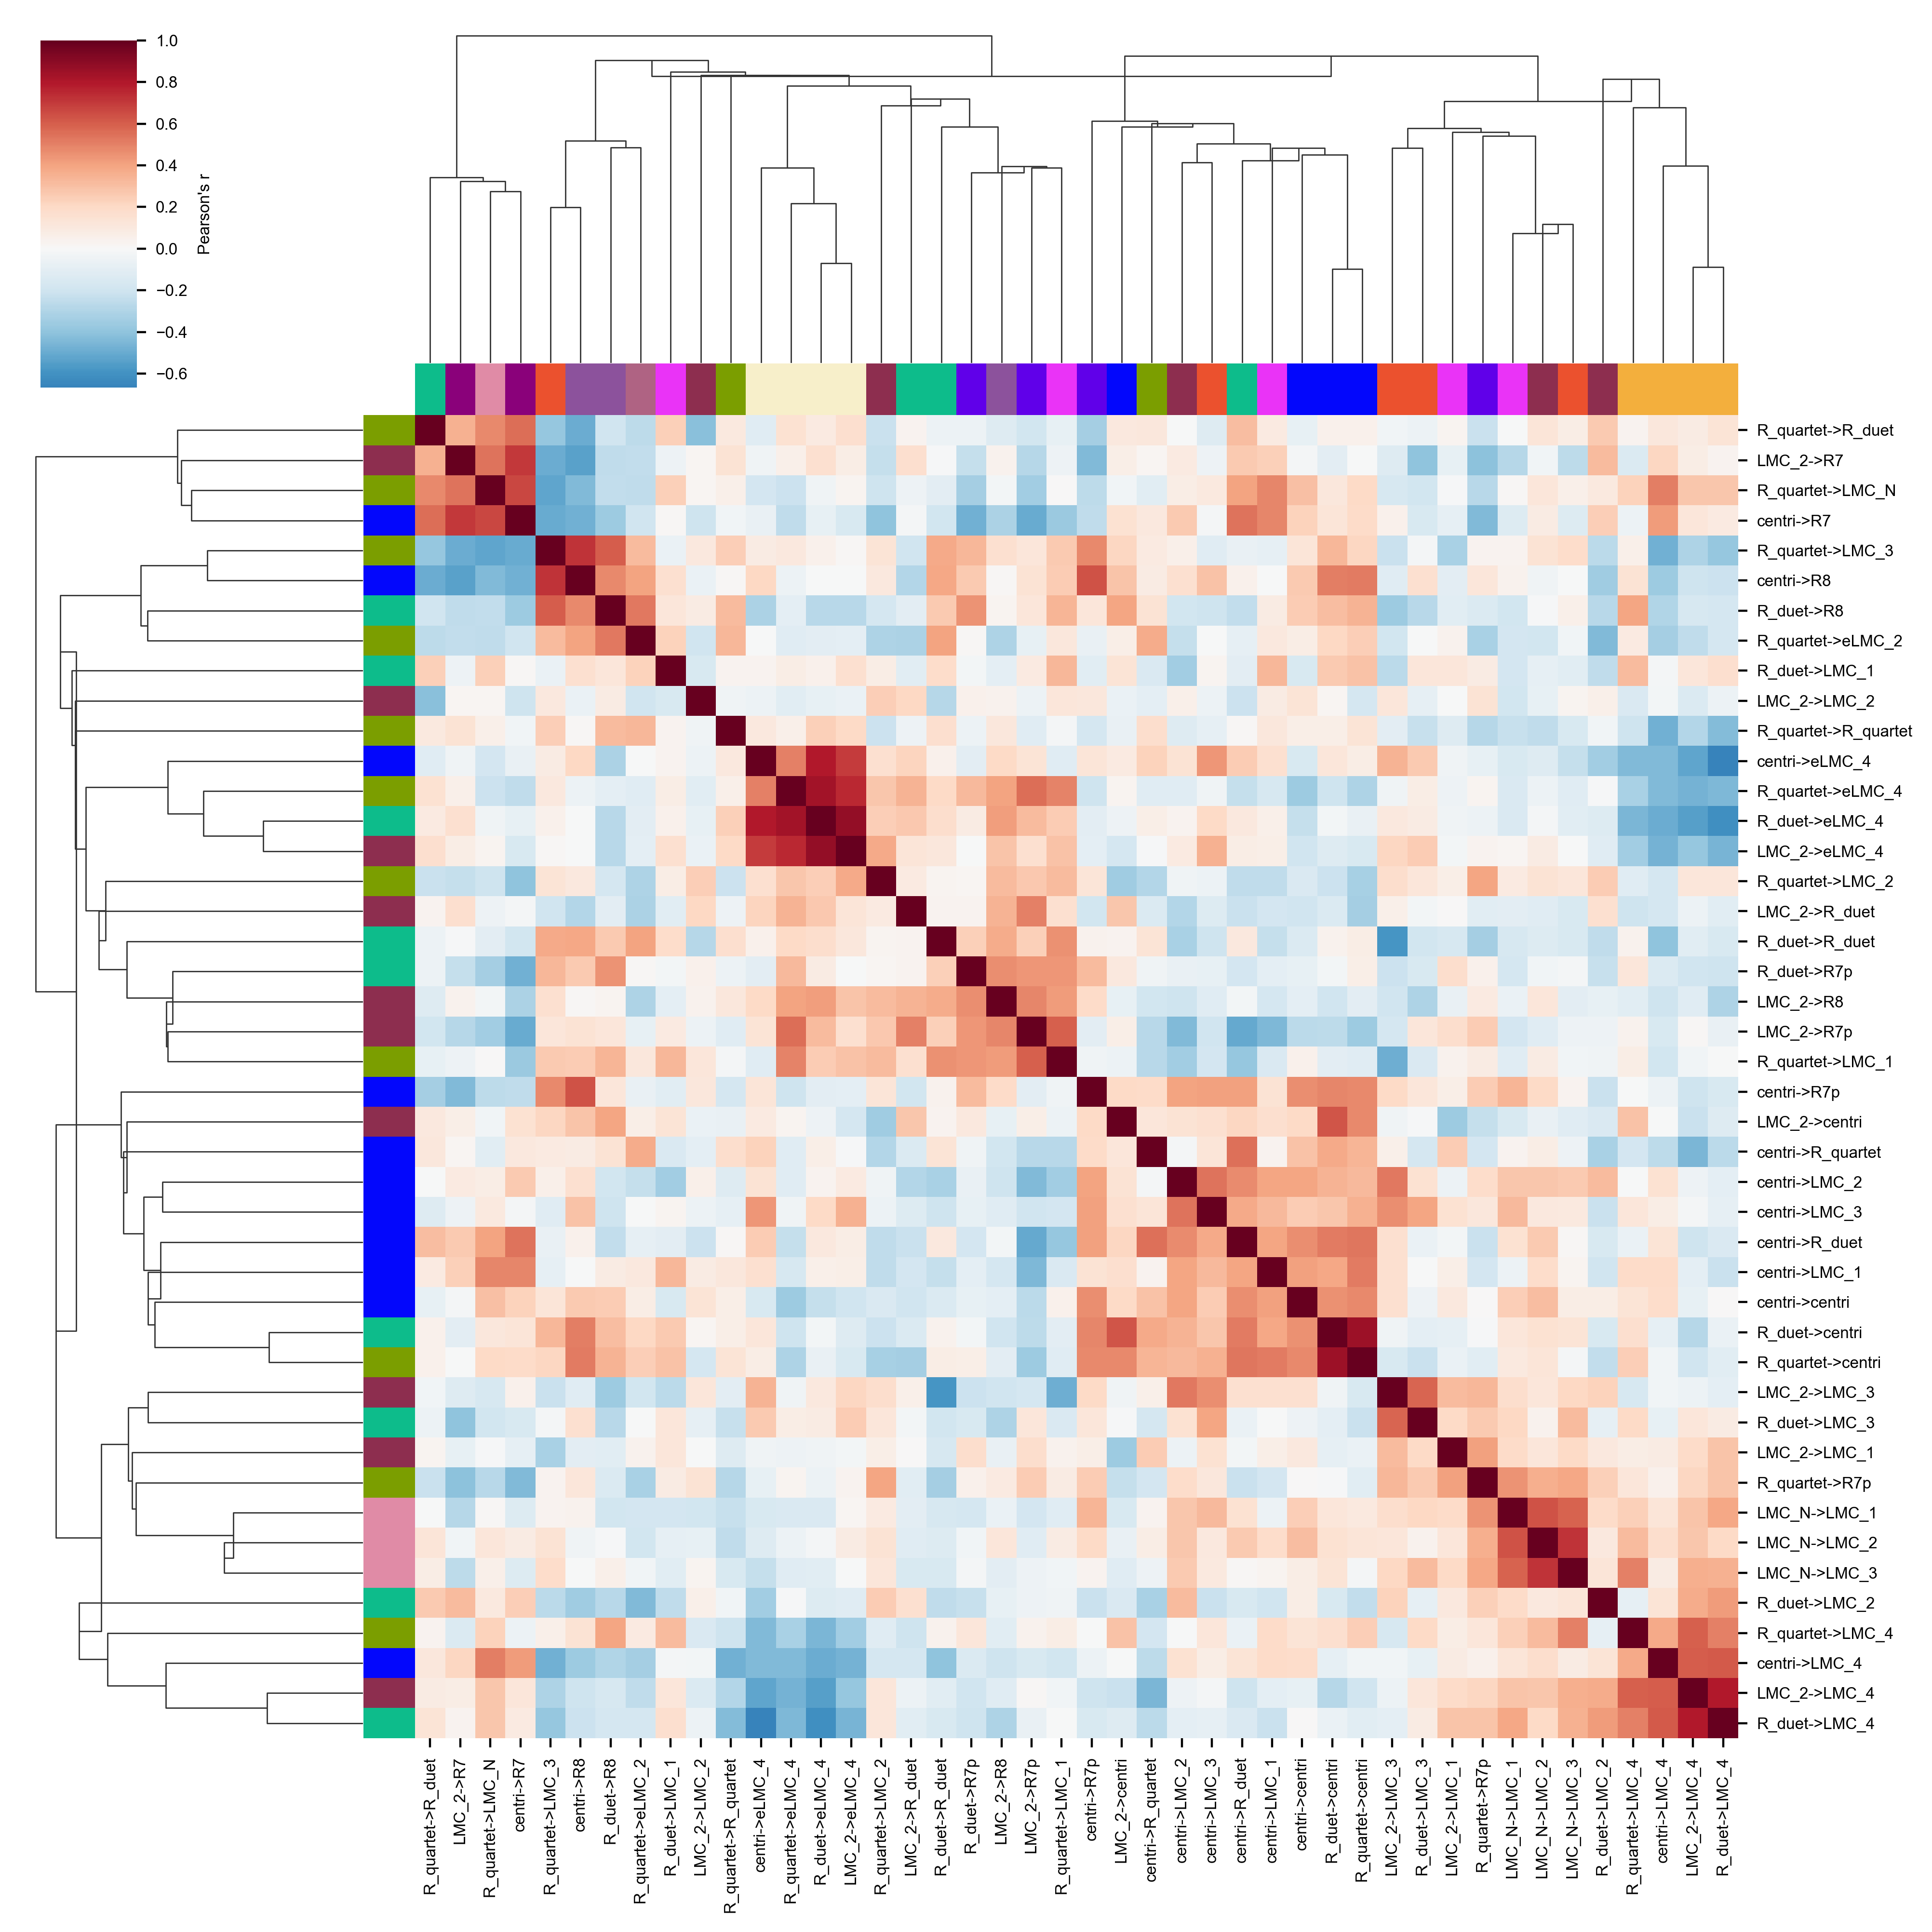

In [5]:
# INCLUDE INTEROM CONNECTIONS
data = cxvecs

z = data.apply(zscore)
corr_z = z.corr()
#print(corr_z)

x_c = [cm[x.split('->')[0]] for x in corr_z.index]
y_c = [cm[x.split('->')[1]] for x in corr_z.columns]

clus = sns.clustermap(corr_z, metric='euclidean', method='centroid', 
                      cmap='RdBu_r', cbar_kws={'label': "Pearson's r"}, center=0, 
                      row_colors=x_c, col_colors=y_c)
if save_figs:
    clus.savefig(fig_path + f'cx-clus_all-cx-mean1.svg')
    clus.savefig(fig_path + f'om-clus_all-cx-mean1.png')

<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class '

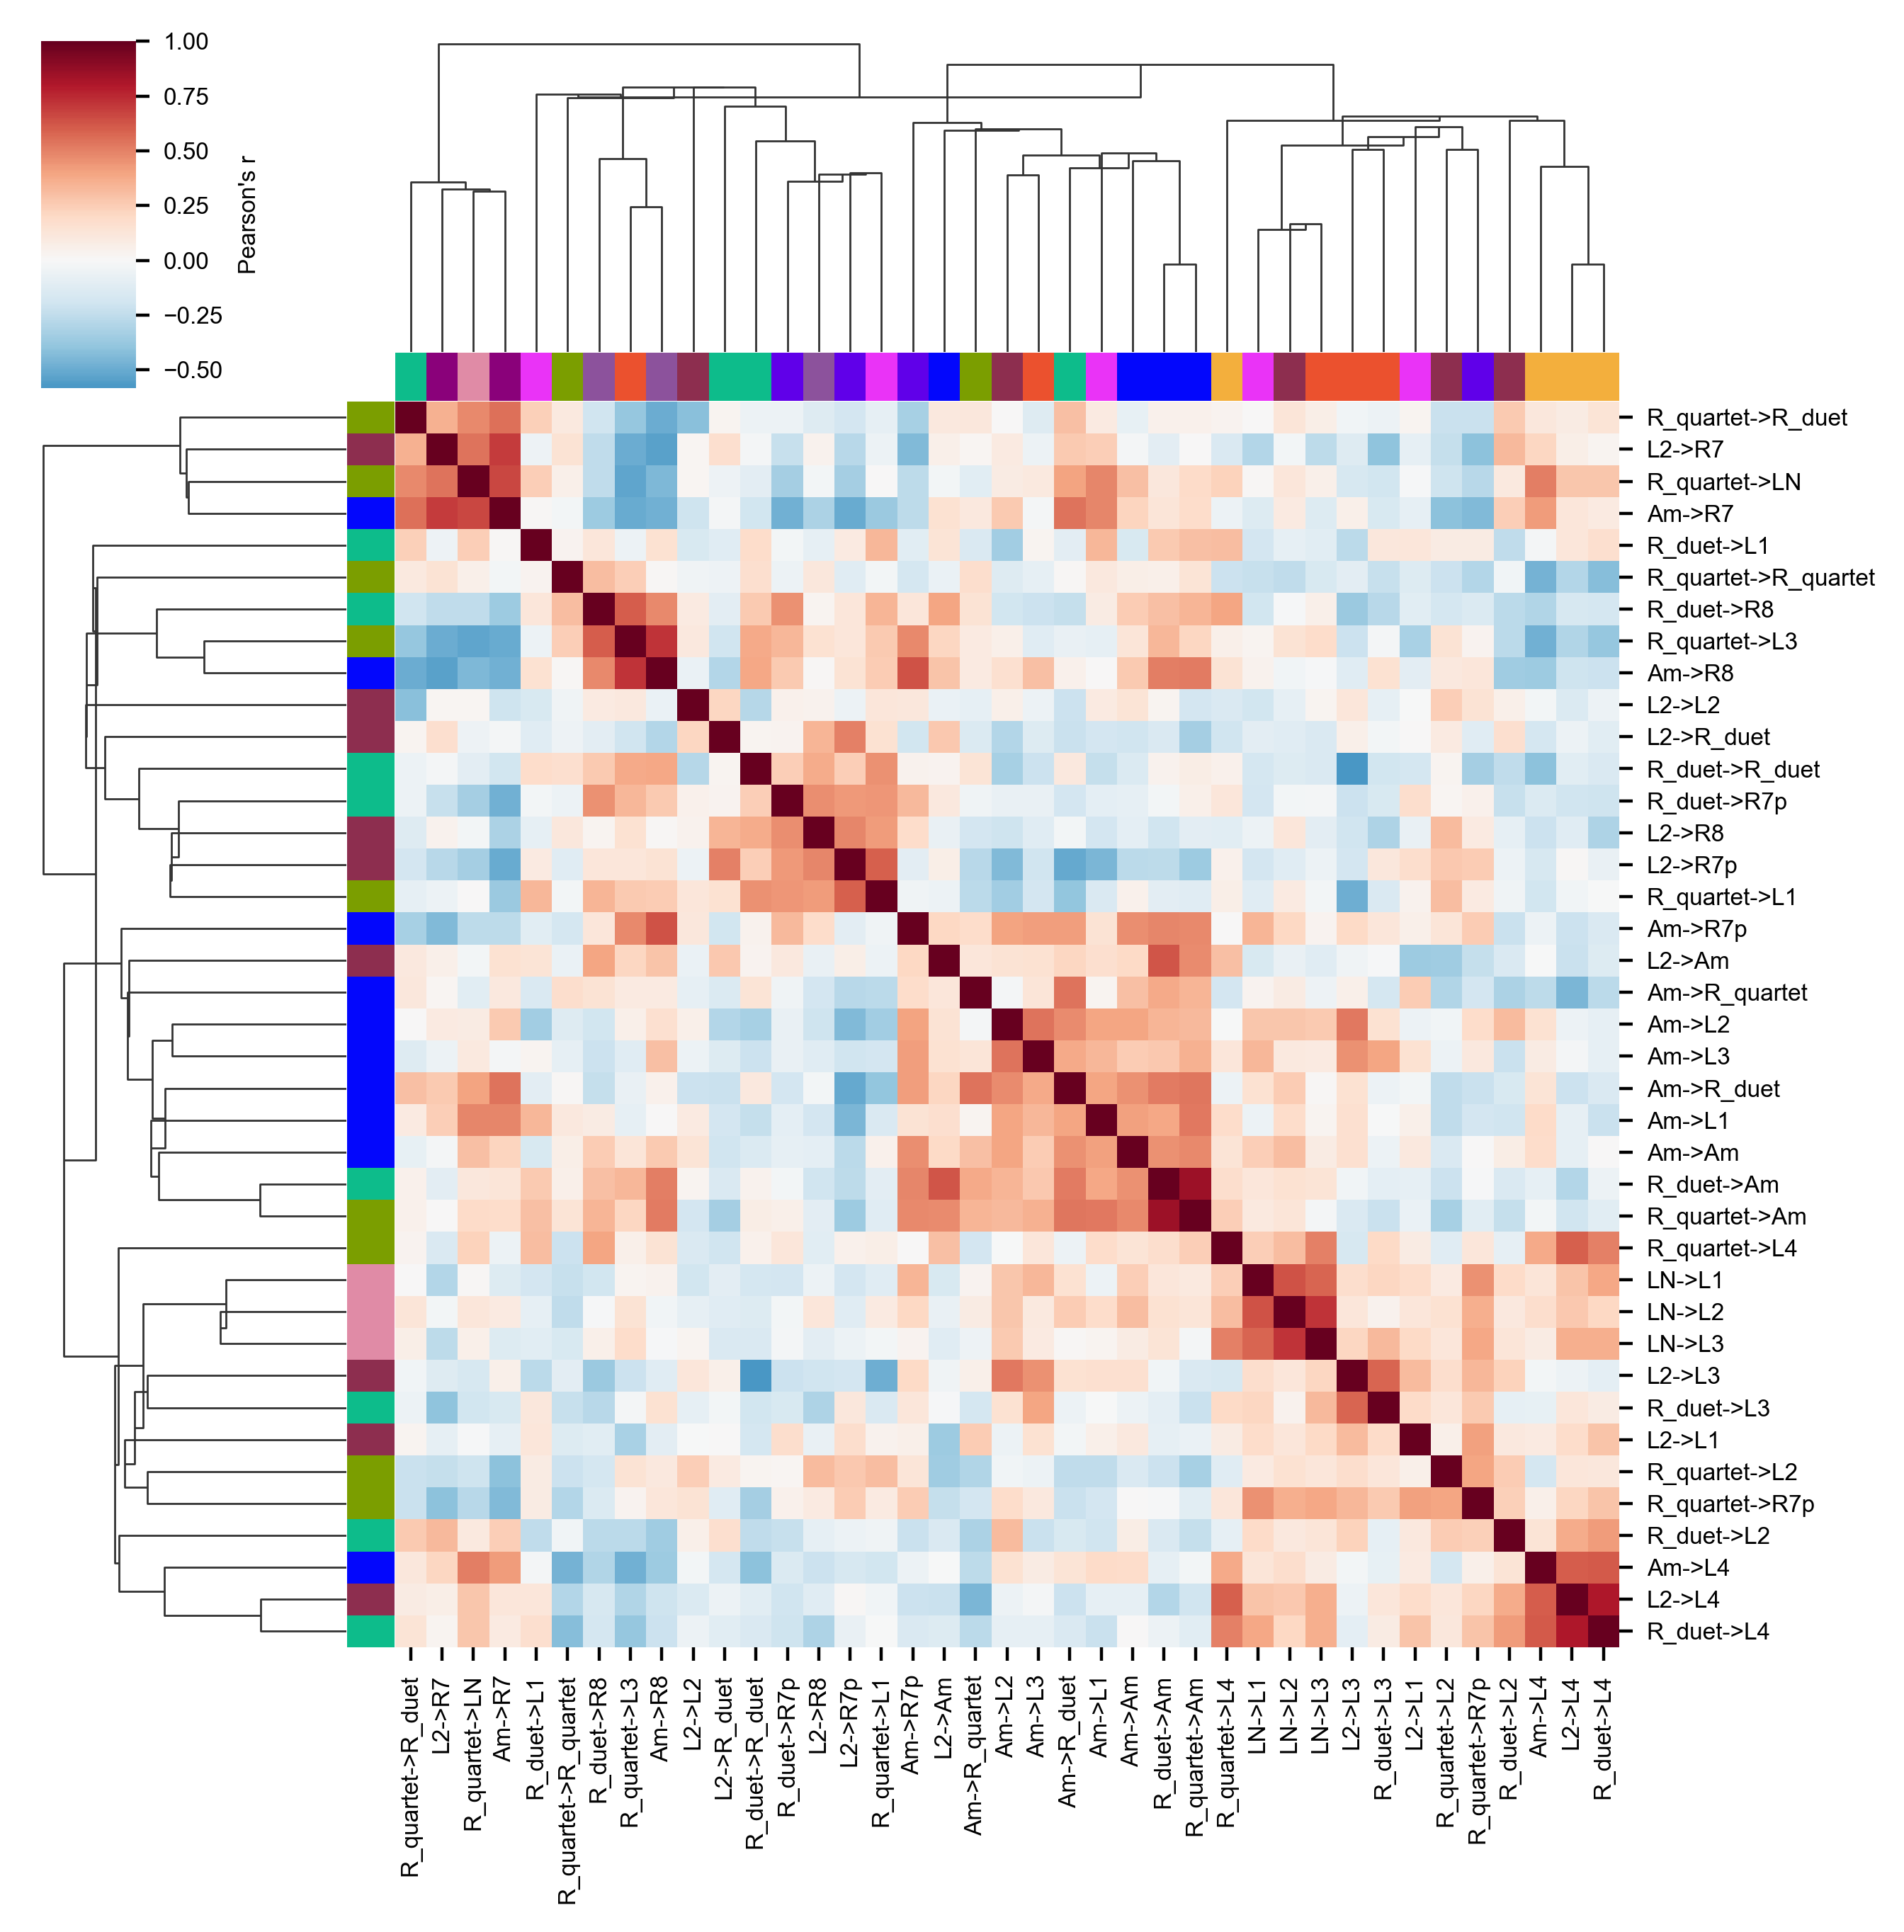

In [6]:
# EXCLUDE INTEROM CONNECTIONS
home_cx = [cx for cx in cxvecs.columns if '->e' not in cx]
data = cxvecs.filter(items=home_cx)
z = data.apply(zscore)
corr_z = z.corr()
#print(corr_z)

x_c = [cm[x.split('->')[0]] for x in corr_z.index]
y_c = [cm[x.split('->')[1]] for x in corr_z.columns]

clus = sns.clustermap(corr_z, metric='euclidean', method='centroid', 
                      cmap='RdBu_r', cbar_kws={'label': "Pearson's r"}, center=0, 
                      row_colors=x_c, col_colors=y_c, figsize=[6.7, 6.8]) #fontdict={'fontsize': 6.0})
new_labels = []
for l in clus.ax_heatmap.axes.get_xticklabels():
    mpl.rcParams['font.family'] = ['arial', 'sans-serif']
    mpl.rcParams['font.size'] = 6.0
#     mpl.rcParams['sans-serif'] = ['Arial']
#     l.set_text('font.size'=6.0)
#     l.set_text('font.name'='Arial')
    print(type(l))
    if 'centri' in l.get_text():
        l.set_text(l.get_text().replace('centri', 'Am'))

    
    if 'LMC_' in l.get_text():
        l.set_text(l.get_text().replace('LMC_', 'L'))
           
    
    new_labels.append(l)
clus.ax_heatmap.axes.set_xticklabels(new_labels)

new_labels = []
for l in clus.ax_heatmap.axes.get_yticklabels():
    mpl.rcParams['font.family'] = ['arial', 'sans-serif']
    mpl.rcParams['font.size'] = 6.0
    print(type(l))
    if 'centri' in l.get_text():
        l.set_text(l.get_text().replace('centri', 'Am'))

    
    if 'LMC_' in l.get_text():
        l.set_text(l.get_text().replace('LMC_', 'L'))
           
    
    new_labels.append(l)
clus.ax_heatmap.axes.set_yticklabels(new_labels)

if save_figs:
    clus.savefig(fig_path + f'cx-clus_all-cx-mean1_EXCLUDE-interom.svg')
    clus.savefig(fig_path + f'om-clus_all-cx-mean1_EXCLUDE-interom.png')